# Mixture Density Networks (MDN)

In this lab of the **ErSE 222 - Machine Learning in Geoscience** course, we will learn about a special type of Neural Networks, called Mixture Density Networks (MDN). Their key feature is that of producing (possibly) multi-modal probabistic estimates of the network predictions parametrized as a mixture of gaussian with learned mean, standard deviation and weighting. 

When compared to standard NNS, MDNs present two 3 unique elements:

- A network that comprises of a:
    
    i) backbone: takes $x \in R^{N}$ as input and produces $z \in R^{M}$
    
    ii) mixture-density layer: takes $z \in R^{M}$ as input to 3 distinct linear layers and produces $\mu \in R^{N_c}$, $\sigma \in R^{N_c}$, $\pi \in R^{N_c}$ where $N_c$ is the number of gaussians in the mixture. Note that since we want $\sigma$ to be always positive we pass this through a modified ELU activation. Similarly since we want $\sum_j \pi_j=1$ we pass them through a softmax (here done implicitely by passing the raw outputs to a `OneHotCategorical` distribution.
     
- A loss: negative log-likelihood (NLL). Here we first define the likelihood of the gaussian mixture

    $$
    p(y|x) = \sum_{j=1}^{N_c} \pi_j \frac{1}{\sqrt{2 \pi \sigma_j^2}} e^\frac{-(y-\mu_j)^2}{2 \sigma_j^2}
    $$
    
    The NLL becomes:
    
    $$
    -log(p(y|x)) = -log \left( \sum_{j=1}^{N_c} \pi_j log(p_j(y|x)\right)
    $$
    
    where $log(p_j(y|x))=\frac{1}{\sqrt{2 \pi \sigma_j^2}} e^\frac{-(y-\mu_j)^2}{2 \sigma_j^2}$.
    
    However since we are applying a logarithm to a function that involved and exponential operation this may be unstable. We therefore prefer to write an equivalent form NLL:
    
    $$
    -log(p(y|x)) = -log \left( \sum_{j=1}^{N_c} e^{log(\pi_j) + log(p_j(y|x))}\right)
    $$
    
    As you can see the formula is the same as $a*b = e^{log(a*b)} = e^{log(a)+log(b)} $
    
    Evaluating the first term of the exponent is easy given $\pi_j$. For the second term we can write its analytical expression:
    
    $$
    log(p_j(y|x)) = -log(\sigma_j) - log(2 \pi)/2 - \frac{(y-\mu_j)^2}{2 \sigma_j^2}
    $$
    
- A regularization (optional): MDN are hard to train due to the tendency of mode collapse. A single gaussian in the mixture is favoured and all the others are ignored. There is no ultimate solution to this problem but careful regularization can mitigate it. Two simple regularizations seem to help:

    i)  Weight Regularization: the L1 or L2 norms of the weights of the neurons which compute the mean, variances and mixing components are penalized.

    ii) Bias Initialization: if an initial estimate of the means of the gaussians is available we can initialize the bias of the mean layers to these centers.
    
    
This notebook is organized as follows:

- A MDN is used to learn a probabilistic model from a data generated using a linear function with non-stationary noise;
- A MDN is used to learn a probabilistic model from a data generated using a gaussian mixture;
- A MDN is used to produce a probabilistic estimate of a missing well log from a suite of logs (we will use the same data as in one of our previous labs)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random
import numpy as np
import pandas as pd

from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from torch.utils.data import TensorDataset, DataLoader 
from torch.distributions import Categorical
from torch.distributions import Normal, OneHotCategorical
from torch import optim

In [2]:
def set_seed(seed):
    """Set all random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled   = False

    return True

In [3]:
class BackboneNetwork(nn.Module):
    def __init__(self, in_dim, hidden_dims):
        super().__init__()
        # Backbone 
        hidden_dims = [in_dim, ] + hidden_dims
        seq = []
        for i in range(len(hidden_dims)-1):
            seq.append(nn.Linear(hidden_dims[i], hidden_dims[i+1], bias=True))
            seq.append(nn.ReLU())
        self.backbone = nn.Sequential(*seq) # remove last relu
     
    def forward(self, x):
        return self.backbone(x)

class NormalNetwork(nn.Module):
    def __init__(self, in_dim, out_dim, n_components):
        super().__init__()
        self.n_components = n_components
        self.network = nn.Linear(in_dim, 2 * out_dim * n_components)

    def forward(self, x):
        params = self.network(x)
        mean, sd = torch.split(params, params.shape[1] // 2, dim=1)
        sd = nn.ELU()(sd) + 1 + 1e-15
        mean = torch.stack(mean.split(mean.shape[1] // self.n_components, 1))
        sd = torch.stack(sd.split(sd.shape[1] // self.n_components, 1))
        return Normal(mean.transpose(0, 1), sd.transpose(0, 1)), (mean, sd) # with ELU 
    
class CategoricalNetwork(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.network = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        params = self.network(x)
        return OneHotCategorical(logits=params), params
    

class MixtureDensityNetwork(nn.Module):
    def __init__(self, in_dim, out_dim, n_components, hidden_dims=[8, ]):
        super().__init__()
        self.backbone_network = BackboneNetwork(in_dim, hidden_dims)
        self.pi_network = CategoricalNetwork(hidden_dims[-1], n_components)
        self.normal_network = NormalNetwork(hidden_dims[-1], out_dim, n_components)

    def forward(self, x):
        x = self.backbone_network(x)
        return self.pi_network(x), self.normal_network(x)

    def loss(self, x, y):
        (pi, _), (normal, _) = self.forward(x)
        loglik = normal.log_prob(y.unsqueeze(1).expand_as(normal.loc))
        loglik = torch.sum(loglik, dim=2)
        loss = -torch.logsumexp(torch.log(pi.probs) + loglik, dim=1)
        return loss

    def sample(self, x):
        (pi, logits), (normal, (mu, sigma)) = self.forward(x)
        samples = torch.sum(pi.sample().unsqueeze(2) * normal.sample(), dim=1)
        return samples, (mu, sigma, logits)

In [4]:
def train(model, optimizer, data_loader, device='cpu'):
    model.train()
    loss = 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)            
        optimizer.zero_grad()
        ls = model.loss(X, y).mean()
        ls.backward()
        optimizer.step()
        loss += ls.item()
    loss /= len(data_loader)
    return loss

In [5]:
def evaluate(model, data_loader, device='cpu'):
    model.eval()
    loss = 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)            
        with torch.no_grad(): # use no_grad to avoid making the computational graph...
            ls = model.loss(X, y).mean()    
        loss += ls.item()
    loss /= len(data_loader)
    return loss

In [6]:
def training(network, optim, nepochs, train_loader, valid_loader, device='cpu'):
    iepoch_best = 0
    train_loss_history = np.zeros(nepochs)
    valid_loss_history = np.zeros(nepochs)
    for i in range(nepochs):
        train_loss = train(network, optim, train_loader, device=device)
        valid_loss = evaluate(network, valid_loader, device=device)
        train_loss_history[i] = train_loss
        valid_loss_history[i] = valid_loss
        if i % 10 == 0:
            print(f'Epoch {i}, Training Loss {train_loss:.3f}, Test Loss {valid_loss:.3f}')
    return train_loss_history, valid_loss_history

As usual let's begin by checking we have access to a GPU and tell Torch we would like to use it:

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Linear function with non-stationary noise

Let's generate some synthetic data composed of a straigh line to which we add gaussian noise whose standard deviation is proportional to the square of the input.

$$
y=5x + n, \quad n \sim N(0, x^2)
$$

We are using here the code in this excellent [tutorial](https://towardsdatascience.com/mixture-density-networks-probabilistic-regression-for-uncertainty-estimation-5f7250207431).

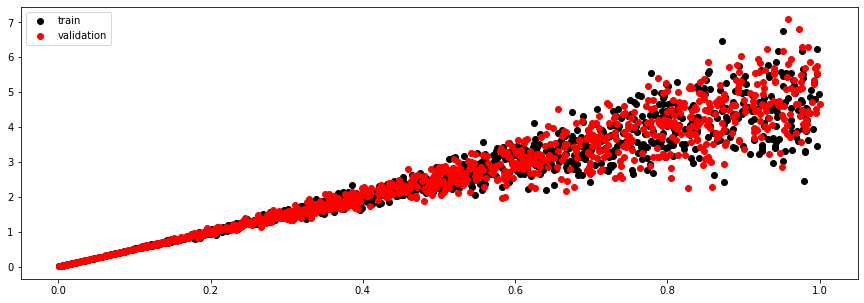

In [8]:
nsamples = 2048

# generate data
x_data = np.random.sample(nsamples)[:, np.newaxis].astype(np.float32)
y_data = np.add(5*x_data, np.multiply((x_data)**2, np.random.standard_normal(x_data.shape)))

# divide in train and validation
x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=0.5, random_state=42)

# define test data inputs
x_test = np.linspace(0.,1.,int(1e3))[:, np.newaxis].astype(np.float32)

plt.figure(figsize=(15, 5))
plt.scatter(x_train, y_train, c='k', label='train')
plt.scatter(x_valid, y_valid, c='r', label='validation')
plt.legend();

Let's start by creating a network composed of a deep backbone (2 layers with 20 and 10 hidden units) and training it with our usual training strategy

In [9]:
# Define Train Set
x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train)

train_dataset = TensorDataset(x_train, y_train)

# Define Valid Set
x_valid = torch.Tensor(x_valid)
y_valid = torch.Tensor(y_valid)

valid_dataset = TensorDataset(x_valid, y_valid)

# Create DataLoaders fixing the generator for reproducibily
g = torch.Generator()
g.manual_seed(0)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, generator=g)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

MixtureDensityNetwork(
  (backbone_network): BackboneNetwork(
    (backbone): Sequential(
      (0): Linear(in_features=1, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=10, bias=True)
      (3): ReLU()
    )
  )
  (pi_network): CategoricalNetwork(
    (network): Linear(in_features=10, out_features=1, bias=True)
  )
  (normal_network): NormalNetwork(
    (network): Linear(in_features=10, out_features=2, bias=True)
  )
)
Epoch 0, Training Loss 3.036, Test Loss 2.575
Epoch 10, Training Loss 1.590, Test Loss 1.569
Epoch 20, Training Loss 0.866, Test Loss 0.838
Epoch 30, Training Loss 0.589, Test Loss 0.585
Epoch 40, Training Loss 0.293, Test Loss 0.269
Epoch 50, Training Loss 0.013, Test Loss 0.007
Epoch 60, Training Loss -0.193, Test Loss -0.107
Epoch 70, Training Loss -0.285, Test Loss -0.228
Epoch 80, Training Loss -0.301, Test Loss -0.285
Epoch 90, Training Loss -0.320, Test Loss -0.296
Epoch 100, Training Loss -0.280, Test Loss -0.268
Epo

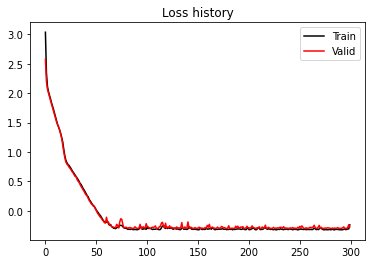

In [10]:
set_seed(5)
model = MixtureDensityNetwork(1, 1, n_components=1, hidden_dims=[20,10])
print(model)

nepochs = 300
optimizer = optim.Adam(model.parameters(), lr=0.005)

train_loss_history, valid_loss_history = \
    training(model, optimizer, nepochs, train_loader, valid_loader, device=device)

plt.figure()
plt.plot(train_loss_history, 'k', label='Train')
plt.plot(valid_loss_history, 'r', label='Valid')
plt.title('Loss history')
plt.legend();

We can now perform some predictions, first using our training data as input

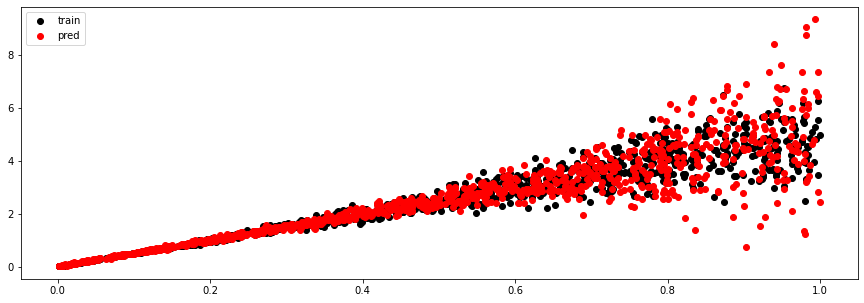

In [11]:
y_train_pred, (mu, sigma, logits) = model.sample(x_train)

plt.figure(figsize=(15, 5))
plt.scatter(x_train, y_train, c='k', label='train')
plt.scatter(x_train, y_train_pred, c='r', label='pred')
plt.legend();

And now using the test data (which is uniformly sampled over the x axis)

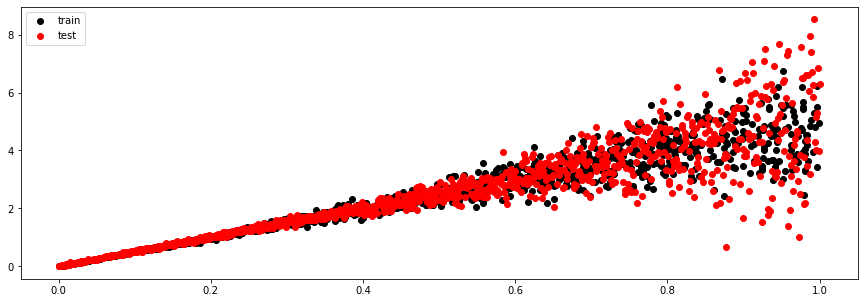

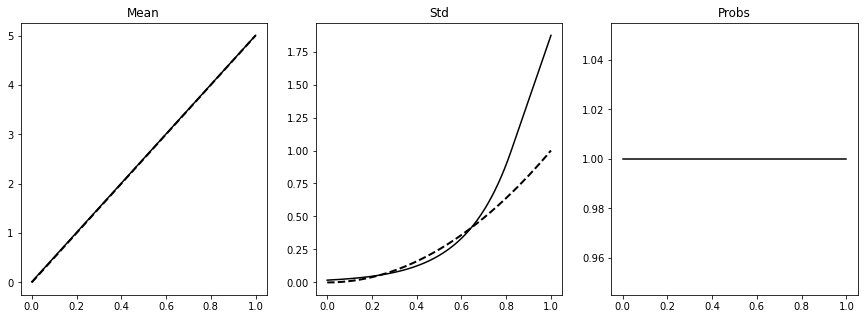

In [12]:
x_test = torch.Tensor(x_test)
y_test, (mu, sigma, logits) = model.sample(x_test)
pi = nn.functional.softmax(logits, dim=-1)
mu_test = 5*x_test
std_test = x_test**2

plt.figure(figsize=(15, 5))
plt.scatter(x_train, y_train, c='k', label='train')
plt.scatter(x_test, y_test, c='r', label='test')
plt.legend();

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(x_test.ravel(), mu.detach().numpy().squeeze().T, 'k')
axs[0].plot(x_test.ravel(), mu_test, '--k', lw=2)
axs[0].set_title('Mean')
axs[1].plot(x_test.ravel(), sigma.detach().numpy().squeeze().T, 'k')
axs[1].plot(x_test.ravel(), std_test, '--k', lw=2)
axs[1].set_title('Std')
axs[2].plot(x_test.ravel(), pi.detach().numpy(), 'k')
axs[2].set_title('Probs');

## Gaussian Mixture

Let's now generate some synthetic data composed of a mixture of two gaussians

Here we slightly modify the data generation procedure from this [tutorial](https://towardsdatascience.com/mixture-density-networks-probabilistic-regression-for-uncertainty-estimation-5f7250207431).

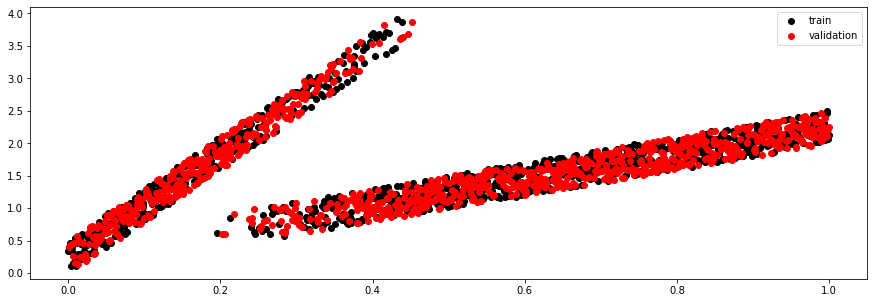

In [13]:
nsamples = 2048

#x_data = np.random.sample(nsamples)[:, np.newaxis].astype(np.float32)
x_data = np.linspace(0,1,nsamples)[:, np.newaxis].astype(np.float32)
pi = np.sin(x_data)+3*x_data*np.cos(x_data) + 1.*np.random.sample(nsamples)[:, np.newaxis]
pi = pi/pi.max()
g1 = 2*x_data.squeeze() + 0.5*np.random.sample(nsamples)
g2 = 8*x_data.squeeze() + 0.5*np.random.sample(nsamples)

y_data = pi.round().squeeze()*g1 + (1-pi.round().squeeze())*g2
y_data = y_data.reshape(-1,1)
x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=0.5, random_state=42)
x_test = np.linspace(0.,1.,int(1e3))[:, np.newaxis].astype(np.float32)

plt.figure(figsize=(15, 5))
plt.scatter(x_train, y_train, c='k', label='train')
plt.scatter(x_valid, y_valid, c='r', label='validation')
plt.legend();

In [14]:
# Define Train Set
X_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

train_dataset = TensorDataset(X_train, y_train)

# Define Valid Set
X_valid = torch.from_numpy(x_valid).float()
y_valid = torch.from_numpy(y_valid).float()

valid_dataset = TensorDataset(X_valid, y_valid)

# Create DataLoaders fixing the generator for reproducibily
g = torch.Generator()
g.manual_seed(0)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, generator=g)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

MixtureDensityNetwork(
  (backbone_network): BackboneNetwork(
    (backbone): Sequential(
      (0): Linear(in_features=1, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=10, bias=True)
      (3): ReLU()
    )
  )
  (pi_network): CategoricalNetwork(
    (network): Linear(in_features=10, out_features=2, bias=True)
  )
  (normal_network): NormalNetwork(
    (network): Linear(in_features=10, out_features=4, bias=True)
  )
)
Epoch 0, Training Loss 1.789, Test Loss 1.506
Epoch 10, Training Loss 0.541, Test Loss 0.527
Epoch 20, Training Loss 0.212, Test Loss 0.244
Epoch 30, Training Loss -0.070, Test Loss -0.103
Epoch 40, Training Loss -0.276, Test Loss -0.304
Epoch 50, Training Loss -0.318, Test Loss -0.355
Epoch 60, Training Loss -0.342, Test Loss -0.369
Epoch 70, Training Loss -0.329, Test Loss -0.367
Epoch 80, Training Loss -0.340, Test Loss -0.384
Epoch 90, Training Loss -0.347, Test Loss -0.384
Epoch 100, Training Loss -0.350, Test Loss -0.3

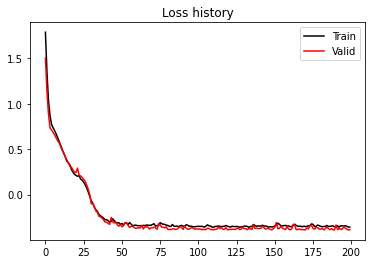

In [15]:
set_seed(5)
model = MixtureDensityNetwork(1, 1, n_components=2, hidden_dims=[20,10])
print(model)

nepochs = 200
optimizer = optim.Adam(model.parameters(), lr=0.005)

train_loss_history, valid_loss_history = \
    training(model, optimizer, nepochs, train_loader, valid_loader, device=device)

plt.figure()
plt.plot(train_loss_history, 'k', label='Train')
plt.plot(valid_loss_history, 'r', label='Valid')
plt.title('Loss history')
plt.legend();

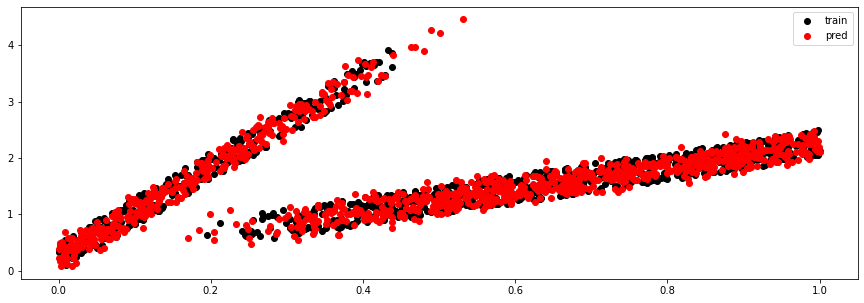

In [16]:
y_train_pred, (mu, sigma, logits) = model.sample(X_train)

plt.figure(figsize=(15, 5))
plt.scatter(X_train, y_train, c='k', label='train')
plt.scatter(X_train, y_train_pred, c='r', label='pred')
plt.legend();

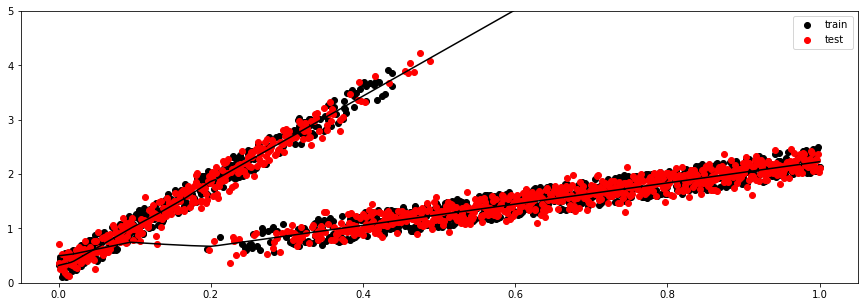

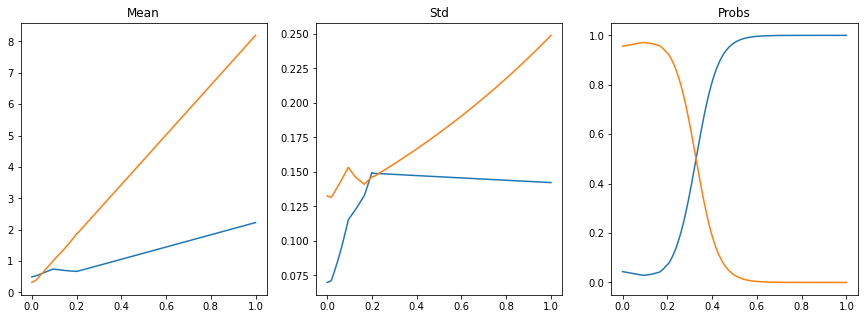

In [17]:
x_test = torch.Tensor(x_test)
y_test, (mu, sigma, logits) = model.sample(x_test)
pi = nn.functional.softmax(logits, dim=-1)

plt.figure(figsize=(15, 5))
plt.scatter(x_train, y_train, c='k', label='train')
plt.scatter(x_test, y_test, c='r', label='test')
plt.plot(x_test.ravel(), mu.detach().numpy().squeeze().T, 'k')
plt.legend()
plt.ylim(0,5)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(x_test.ravel(), mu.detach().numpy().squeeze().T)
axs[0].set_title('Mean')
axs[1].plot(x_test.ravel(), sigma.detach().numpy().squeeze().T)
axs[1].set_title('Std')
axs[2].plot(x_test.ravel(), pi.detach().numpy())
axs[2].set_title('Probs');

/Users/ravasim/opt/anaconda3/envs/mlcourse/lib/python3.8/site-packages/numpy/core/_asarray.py:102: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order)


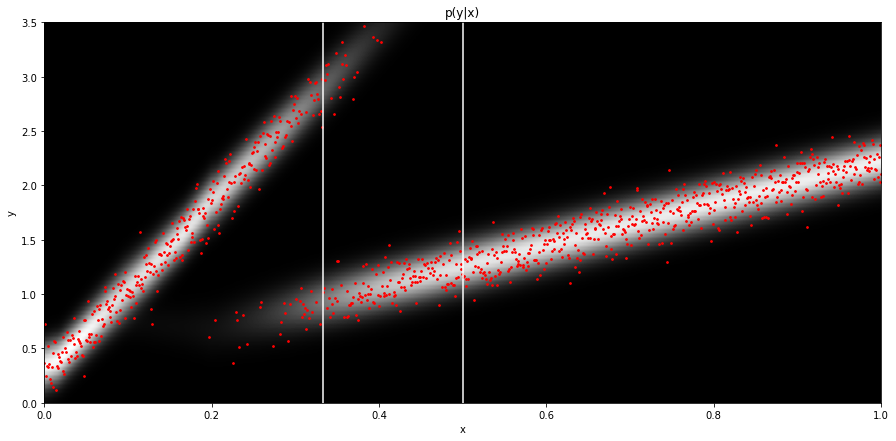

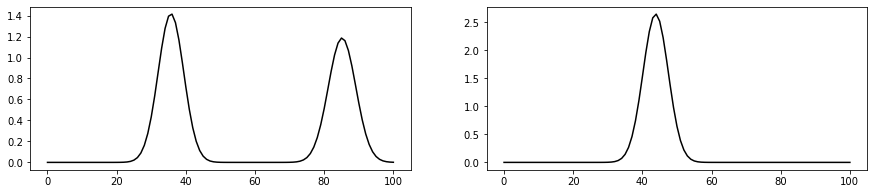

In [18]:
nyax = 101
yax = np.linspace(-0.5, 3.5, nyax)
Py = np.zeros((len(x_test), nyax))
for i in range(len(x_test)):
    Py[i] = pi[i, 0].detach().numpy() * norm.pdf(yax, float(mu[0, i,0].detach().numpy()), float(sigma[0, i, 0].detach().numpy())) + \
            pi[i, 1].detach().numpy() * norm.pdf(yax, float(mu[1, i,0].detach().numpy()), float(sigma[1, i, 0].detach().numpy()))   
    
plt.figure(figsize=(15, 7))
plt.imshow(Py.T, cmap='gray', extent=(x_test[0][0], x_test[-1][0], 3.5, -0.5))
plt.scatter(x_test.ravel(), y_test.ravel(), c='r', s=3)
plt.axvline(x_test[len(x_test)//3], c='w')
plt.axvline(x_test[len(x_test)//2], c='w')
plt.xlabel('x')
plt.ylabel('y')
plt.title('p(y|x)')
plt.axis('tight')
plt.ylim(0, 3.5);

fig, axs = plt.subplots(1, 2, figsize=(15, 3))
axs[0].plot(Py[len(x_test)//3], 'k')
axs[1].plot(Py[len(x_test)//2], 'k')

## Well log probabilistic prediction